# 简单了解 SISSO 特征筛选方法在回归问题下应用

这份文档我们会用玩具模型，简单地讨论 SISSO 的使用与输出。我们会尽可能地理解所有程序的输出文件，但对于 (我所认为的) SISSO 的最关键的两个技术问题，即特征自动构造以及高性能筛选 (以及 $L_0$ 惩罚的算子选择算法) 问题，我们不做讨论。

SISSO (Sure Independence Screening and Sparsifying Operator) 是 <cite data-cite="Ouyang-Ghiringhelli.PRM.2018.2">Ouyang PRM 2018</cite> <cite data-cite="Ouyang-Ghiringhelli.JPM.2019.2">Ouyang JPM 2019</cite> 提出的算法。针对回归问题，通过用户给定一系列数据的特征 (Feature) 和目标值 (Target or Property)，以及一些 SISSO 特化的设定，可以导出哪些特征、以及特征间的运算所导出的描述子 (Descriptor) (运算包括但不限于四则运算、指数与对数、三角函数等) 会对目标值有最大程度的贡献；从而达到筛选出能最佳地描述目标的描述子的目的。

该算法尽管是出于解决材料设计问题而产生的，但它本身完全可以看作一种纯应用数学的方法。同时，该算法的根基应当被认为是传统机器学习 (非深度学习) 的方法。

由于 SISSO 并不是 Python 程序，因此这份文档中，我们会在 Jupyter 中使用 bash 命令。为了执行这份文档，读者需要事先编译好 SISSO 程序到当前目录的 `sisso`。

In [38]:
%matplotlib notebook

import numpy as np
from numpy import exp, sqrt, log, sin, cos
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, max_error, r2_score
from matplotlib import pyplot as plt

np.set_printoptions(precision=5, linewidth=150, suppress=True)

## 运行前的准备

### 数据集 (Dataset)

数据集的构造如下。该数据集的样本数量为 5；目标值在第二列，三个初步的特征列在后三列。该数据集除了名称作简化外，其余与 SISSO Github 上的 [train.dat_regression](https://github.com/rouyang2017/SISSO/blob/master/input_template/train.dat_regression) 一致。

In [39]:
! cat train.dat

materials  property  F1      F2      F3
sample1    3.0862    0.8626  0.7043  0.6312
sample2    2.8854    0.7260  0.7818  0.6119
sample3    0.6907    0.4943  0.0044  0.4420
sample4    0.9902    0.0106  0.0399  0.9877
sample5    0.7242    0.0970  0.3199  0.5504


我们之后会经常地用到这些数据，因此会使用变量与数学记号存储与表示。其中，

- `P` $\boldsymbol{P}$ (vector length: $n_\mathrm{Sample}$) 目标值

- `F1`, `F2`, `F3` $\boldsymbol{f}_1$, $\boldsymbol{f}_2$, $\boldsymbol{f}_3$ (vector length: $n_\mathrm{Sample}$) 初始特征

这里指出，`train.dat` 中的 `F1`, `F2`, `F3` 可以是其它的字符串。同时，这些特征字符串可以通过 Python 的 `exec` statement 直接执行而不一定需要 Hard Coding；但为了程序可读且易执行，在这篇文档中我们就手动地声明这些变量了。

In [40]:
with open("train.dat", "r") as f:
    dataset = np.array([line.split() for line in f.readlines()])
    dataset = np.array(dataset[1:, 1:], dtype=float)
P, F1, F2, F3 = dataset.T
P

array([3.0862, 2.8854, 0.6907, 0.9902, 0.7242])

### SISSO 参数

SISSO 的参数也参考 Github 上的 [SISSO.in_regression](https://github.com/rouyang2017/SISSO/blob/master/input_template/SISSO.in_regression)；但我们对其中一些设置做了更改。一些重要但也许需要额外说明的参数列举如下：

`desc_dim` 作为最终筛选结果的描述子的维度限制 $n_\mathrm{Descriptor}$。在这篇文档中，我们将“特征”与“描述子”分开；特征是用户输入的样本描述性信息，而描述子是导出的描述性信息。$n_\mathrm{Descriptor}$ 会在后文使用。

In [41]:
! grep "desc_dim=" SISSO.in

desc_dim=3           ! dimension of the descriptor


`rung` 描述子所需要的构造次数。譬如，描述子

- $f_2$ (恰好也是输入特征) 是 Rung 0 级别的；
- $f_2 - f_1$, $\exp(f_1)$ 等是 Rung 1 级别的 (分别使用了减号、指数)；
- $\log(f_3) \mathrm{abs} (f_2 - f_1)$ 是 Rung 2 级别的 (其中，$\log(f_3)$ 与 $\mathrm{abs} (f_2 - f_1)$ 分别是 Rung 1 级别的，它们之间的运算多了一个乘法，因此为 Rung 2 级别的)；
- $\sqrt{\log(f_3)}$ 也是 Rung 2 级别的。

In [42]:
! grep "rung=" SISSO.in

rung=2               ! rung of the feature space to be constructed


`maxcomplexity` 从特征构造描述子时所使用的最多的符号数量。尽管我们设定了最大符号数量为 10，事实上 10 个符号是不可能达到的；因为 Rung 1 最多使用到 1 个符号，Rung 2 最多是两个 Rung 1 描述子的运算即 3 个符号；可以推知 Rung 3 最多使用 7 个符号，Rung $n$ 最多使用 $2^n - 1$ 个符号。

In [43]:
! grep "maxcomplexity=" SISSO.in

maxcomplexity=10     ! max feature complexity (number of operators in a feature)


`dimclass` 第 1, 2 号特征 $f_1$, $f_2$ 共享相同的物理单位，第 3 号特征 $f_3$ 有独立的物理单位。这会避免构造类似于 $f_1 - f_3$ 等不符合量纲的描述子。

In [44]:
! grep "dimclass=" SISSO.in

dimclass=(1:2)(3:3)  ! group features according to their dimension/unit; those not in any () are dimensionless


`subs_sis` 对于每个描述子维度，选取最好的 7 个描述子作为备选 $n_\mathrm{sub}$。后文会对其作补充说明。

In [45]:
! grep "subs_sis=" SISSO.in

subs_sis=7           ! SAME one size for every SIS-selected subspace. Otherwise, input a size for each dimension seperated by comma


## SISSO 运行与结果

当设置完毕数据集 `train.dat` 与 SISSO 设定 `SISSO.in` 后，就可以执行 SISSO 程序 `sisso` 了。SISSO 可以单核计算，也可以 MPI 多核计算。我们将屏幕输出定向到文件 `SISSO.log`，该文件没有实质性内容。

In [46]:
! mpirun -np 4 ./sisso > SISSO.log

[DESKTOP-8BRL880:01147] 3 more processes have sent help message help-btl-vader.txt / cma-permission-denied
[DESKTOP-8BRL880:01147] Set MCA parameter "orte_base_help_aggregate" to 0 to see all help / error messages


但程序会输出大量其他信息。最重要的信息放在 `SISSO.out` 文件中：

In [47]:
! grep -A 10000 "Final model" SISSO.out | grep -B 10000 "===="

Final model/descriptor to report
  3D descriptor (model): 
Total RMSE,MaxAE:   0.000083  0.000137
@@@descriptor: 
                      5:[((F2)^6/log(F1))]
                     12:[(exp(-F3)/abs(F1-F2))]
                     16:[((F1)^3/(F1-F2))]
       coefficients_001:    -0.2813852886E+01    0.2638598223E-01    0.4721473413E-02
          Intercept_001:     0.6547943803E+00
         RMSE,MaxAE_001:     0.8272942564E-04    0.1372716760E-03


这就意味着，从 SISSO 中导出的最佳描述子是 `@@@descriptor:` 下的三个描述子；这三行是所有输出中最为关键的信息：

$$
\begin{align}
D_1 &= f_2^6 \log(f_1)^{-1} \\
D_2 &= \exp(- f_3) |f_1 - f_2|^{-1} \\
D_3 &= f_1^3 (f_1 - f_2)^{-1} \\
\end{align}
$$

这从这三个描述子出发作 (包含截距 Interception，或者称偏置 Bias 的) 线性拟合：

$$
\tilde P = C_1 D_1 + C_2 D_2 + C_3 D_3 + b
$$

可以得到参数 $C_1, C_2, C_3$、偏置 $b$ 与误差 $\boldsymbol{\tilde{P}} - \boldsymbol{P}$ 向量的 RMSE 值与 MaxAE 值。

我们可以用 scikit-learn 来验证上述结果。

In [48]:
D1 = ((F2)**6/log(F1))
D2 = (exp(-F3)/abs(F1-F2))
D3 = ((F1)**3/(F1-F2))

In [49]:
reg = LinearRegression()
reg.fit(np.array([D1, D2, D3]).T, P)

LinearRegression()

线性拟合参数 $C_1, C_2, C_3$ 与偏置 $b$ 列举为

In [50]:
reg.coef_, reg.intercept_

(array([-2.81385,  0.02639,  0.00472]), 0.6547943803493903)

RMSE 误差与 MaxAE 误差分别可以表达为

In [51]:
P_pred = reg.predict(np.array([D1, D2, D3]).T)
sqrt(mean_squared_error(P, P_pred)), max_error(P, P_pred)

(8.272942030223837e-05, 0.0001372716671202978)

如果用户不关心细节与中间输出，我们就只需要了解到这里即可。

## SISSO 第一轮描述子筛选

### 描述子表达式及其在数据点上的值

SISSO 会经历多次描述子筛选。SISSO 每次都会构建数以万计，甚至亿记的描述子空间，随后依据线性拟合判标筛选出最好的 $n_\mathrm{sub}$ 个描述子。我们不讨论 SISSO 是如何构建庞大的描述子空间的过程。**一般来说**，`desc_dim` 的数量决定了特征筛选次数 (如果从特征构造出的描述子的空间不够大，筛选次数会变少；SISSO 会对这种情形作警告)。因此，当前的 SISSO 会有三次特征筛选。筛选的结果会储存在 `feature_space` 目录下。

我们先拿第一次筛选结果讨论。第一次所选出的描述子储存在下述文件中：

In [52]:
! cat feature_space/space_001d.name

((F1*F2)/log(F3))  corr=      0.9953
cos((F1*F2))  corr=      0.9949
((F1*F2))^2  corr=      0.9949
((F1*F2)*(F1+F2))  corr=      0.9948
((F2)^6/log(F1))  corr=      0.9947
((F1)^2*(F2)^3)  corr=      0.9946
((F1*F2)*sqrt(F1))  corr=      0.9938


Python 提供了 `eval` 函数，可以直接将特征的算式读入并作运算。我们使用该功能给出特征运算后得到的描述子矩阵 `d_1D` $\mathbf{d}_\mathrm{1D}$ (matrix dim: $(n_\mathrm{sub}, n_\mathrm{sample})$)。

In [53]:
with open("feature_space/space_001d.name", "r") as f:
    tokens_1D = [line.split()[0].replace("^", "**") for line in f.readlines()]
d_1D = np.array([eval(token) for token in tokens_1D])

In [54]:
d_1D

array([[-1.32034, -1.15554, -0.00266, -0.03417, -0.05197],
       [ 0.82106,  0.8432 ,  1.     ,  1.     ,  0.99952],
       [ 0.36909,  0.32215,  0.     ,  0.     ,  0.00096],
       [ 0.95194,  0.85581,  0.00108,  0.00002,  0.01294],
       [-0.82577, -0.71309, -0.     , -0.     , -0.00046],
       [ 0.25995,  0.25186,  0.     ,  0.     ,  0.00031],
       [ 0.56425,  0.48362,  0.00153,  0.00004,  0.00966]])

譬如第一行代表在所有 $n_\mathrm{sample} = 5$ 个数据点下，运算 $f_1 f_2 \log (f_3)^{-1}$ 的结果：

In [55]:
((F1*F2)/log(F3))

array([-1.32034, -1.15554, -0.00266, -0.03417, -0.05197])

在 SISSO 原文中，也会用 $\boldsymbol{S}_1$ 代表第一轮筛选得到的描述子空间。它只是一种符号表示，而不是可以用程序执行的记号。

### 相关性

我们注意到文件 [feature_space/space_001d.name](feature_space/space_001d.name) 除了包含描述子的具体构造之外，还包括相关性说明。这种相关性实际上是筛选出的描述子与目标值之间的线性相关程度。譬如，对第 0 个描述子，$\boldsymbol{d}_\mathrm{1D}^0$ 即所给出的每个数据点对应的值为

In [56]:
d_1D[0]

array([-1.32034, -1.15554, -0.00266, -0.03417, -0.05197])

这也与文件 [feature_space/space_001d_p001.dat](feature_space/space_001d_p001.dat) 的输出有关。该文件的首列是目标值，随后是描述子在给定数据点上的值：

In [57]:
! cat feature_space/space_001d_p001.dat

    0.3086200000E+01   -0.1320335268E+01    0.8210609668E+00    0.3690917046E+00    0.9519374721E+00   -0.8257705126E+00    0.2599512875E+00    0.5642503915E+00
    0.2885400000E+01   -0.1155542560E+01    0.8432007625E+00    0.3221547755E+00    0.8558073770E+00   -0.7130919424E+00    0.2518606035E+00    0.4836159293E+00
    0.6907000000E+00   -0.2663889108E-02    0.9999976349E+00    0.4730277006E-05    0.1084632604E-02   -0.1029830186E-13    0.2081321883E-07    0.1529109520E-02
    0.9902000000E+00   -0.3417345965E-01    0.9999999106E+00    0.1788782436E-06    0.2135847000E-04   -0.8874049547E-09    0.7137241920E-08    0.4354433812E-04
    0.7242000000E+00   -0.5196747734E-01    0.9995185989E+00    0.9628795181E-03    0.1293653207E-01   -0.4593698157E-03    0.3080251578E-03    0.9664332013E-02


它实际上与目标值有比较好的线性关系：

In [58]:
P

array([3.0862, 2.8854, 0.6907, 0.9902, 0.7242])

可能光是看这两组向量并不能清楚地把握情况。它们的线性关系可能通过两种方式呈现。一种是 Perason R2 的开方，即线性拟合的拟合优度 R 量标：

In [59]:
reg = LinearRegression()
reg.fit(d_1D[0].reshape(-1, 1), P)
np.sqrt(r2_score(P, reg.predict(d_1D[0].reshape(-1, 1))))

0.9952505043650735

上述值与 [feature_space/space_001d.name](feature_space/space_001d.name) 的结果相同。

另一种则是绘图呈现。我们不妨将所有 7 个描述子都用绘图呈现：

<IPython.core.display.Javascript object>


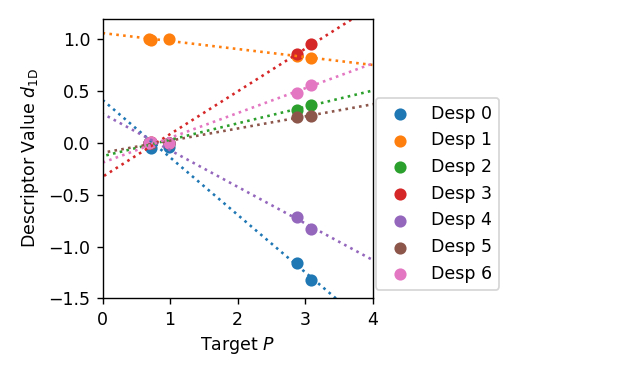

In [60]:
fig, ax = plt.subplots(figsize=(5, 3))
for i, d in zip(range(7), d_1D):
    ax.scatter(P, d, label="Desp {:}".format(i))
    reg = LinearRegression()
    reg.fit(d.reshape(-1, 1), P)
    ax.plot(reg.predict([[-1.5], [1.5]]), [-1.5, 1.5], linestyle=":")
ax.set_xlim(0, 4)
ax.set_ylim(-1.5, 1.2)
ax.set_xlabel("Target $P$")
ax.set_ylabel("Descriptor Value $d_\mathrm{1D}$")
ax.legend(loc='lower right', bbox_to_anchor=(1, 0., 0.5, 0.5))
fig.tight_layout()

### 残差与后一轮描述子筛选准备

第一轮描述子筛选已经结束了；我们需要对第二轮描述子筛选作准备。

第一轮筛选的依据是描述子与目标值 $\boldsymbol{P}$ 相关性。但我们知道，多个描述子之间一般不应当具有较强的相关性，否则这些描述子会被认为是接近线性相关的。

为了尽可能保证第二轮所选取的描述子与第一轮线性无关，第二轮筛选的依据是第一轮描述子中，对目标 $\boldsymbol{P}$ 作线性拟合得到的最低残差 `Delta_1D` $\boldsymbol{\Delta}_\mathrm{1D}$ (vector len: $n_\mathrm{sample}$) (或者说第一轮第 0 个描述子的拟合残差)：

$$
\boldsymbol{\Delta}_\mathrm{1D} = \boldsymbol{P} - \boldsymbol{\tilde{P}} (\boldsymbol{d}_\mathrm{1D}^0)
$$

In [61]:
reg = LinearRegression()
reg.fit(d_1D[0].reshape(-1, 1), P)

LinearRegression()

In [62]:
Delta_1D = P - reg.predict(d_1D[0].reshape(-1, 1)).reshape(-1)
Delta_1D

array([-0.04482,  0.05149, -0.06466,  0.17803, -0.12005])

这与文件 [residual/res_001d_p001.dat](residual/res_001d_p001.dat) 的结果一致：

In [63]:
! cat residual/res_001d_p001.dat

   -0.4481707500E-01
    0.5149135000E-01
   -0.6465814650E-01
    0.1780325505E+00
   -0.1200486783E+00


由于拟合过程中使用到了偏置 (Bias)，因此原文中出现的类似于 $\boldsymbol{\Delta}_\mathrm{1D} = \boldsymbol{P} - \boldsymbol{c}_\mathrm{1D}^{0, \mathrm{T}} \boldsymbol{d}_\mathrm{1D}^0$ 的公式表述会在实现中会有些不同。

## SISSO 第二轮描述子筛选

### 描述子的表达与相关性

第二轮描述子筛选与第一轮过程几乎是相同的；但唯一不同的是筛选描述子的判标从 $\boldsymbol{P}$ 更换到 $\boldsymbol{\Delta}_\mathrm{1D}$。因此，第二轮所选出的描述子几乎都与第一轮的第 0 号描述子某种程度上线性无关；或者说，这些描述子并不是希望能与最终目标值 $\boldsymbol{P}$ 有很好的契合，但其实是契合最终目标与第一轮最好的描述子之间的误差。但第二轮描述子之间又比较线性相关，因为它们都需要较好地线性拟合到相同的 $\boldsymbol{\Delta}_\mathrm{1D}$。

第二轮筛选得到的描述子和相关性列举如下：

In [64]:
! cat feature_space/space_002d.name

(abs(F1-F2))^-1  corr=      0.9693
(sqrt(F3)/abs(F1-F2))  corr=      0.9612
(sin(F3)/abs(F1-F2))  corr=      0.9540
(exp(F3)/abs(F1-F2))  corr=      0.9534
(exp(-F3)/abs(F1-F2))  corr=      0.9486
(F3/abs(F1-F2))  corr=      0.9474
(cos(F2)/abs(F1-F2))  corr=      0.9468


可以将所有第二轮描述子在所有数据点上的值储存到矩阵 `d_2D` $\mathbf{d}_\mathrm{2D}$：

In [65]:
with open("feature_space/space_002d.name", "r") as f:
    tokens_2D = [line.split()[0].replace("^", "**") for line in f.readlines()]
d_2D = np.array([eval(token) for token in tokens_2D])

与第一轮描述子相同地，第二轮描述子空间会记为 $\boldsymbol{S}_2$。

对于第二轮第 0 个描述子，其相对于 $\boldsymbol{\Delta}_\mathrm{1D}$ 所拟合的相关性可以用下述程序给出：

In [66]:
reg = LinearRegression()
reg.fit(d_2D[0].reshape(-1, 1), Delta_1D)
np.sqrt(r2_score(Delta_1D, reg.predict(d_2D[0].reshape(-1, 1))))

0.9692849978551799

这与上述文件的首行信息相同。

### 残差与后一轮描述子筛选准备

从第二轮描述子筛选开始，残差的表达式会较为不同。

我们现在已经筛选出 $2 n_\mathrm{sub} = 2 \times 7 = 14$ 个描述子，我们会记两轮描述子的并空间为 $\boldsymbol{S}_1 \cup \boldsymbol{S}_2$。

如果描述子空间是 $\boldsymbol{S}_1$ 且我们只需要挑出一个描述子来线性拟合最终目标 $\boldsymbol{P}$，那么这个被挑出的最好的描述子就是第一轮中第 0 个描述子。但如果描述子空间是 $\boldsymbol{S}_1 \cup \boldsymbol{S}_2$，并且要挑出两个描述子来线性拟合最终目标 $\boldsymbol{P}$，那就不一定是第一轮第 0 个与第二轮第 0 个描述子了。这种情况下，我们有必要将所有描述子成对地考察一遍。

现在该空间有 14 个描述子；如果允许一对相同的描述子，那么总共有 $14 \times 14 = 196$ 对可能的描述子。我们需要对这 196 种所有可能的情况都作考察；最终判断哪一对描述子是最优秀的。

我们开一个 $(14, 14)$ 大小的矩阵 `rmse_2D`，以 RMSE 为判标，判断一对描述子能否比较好地拟合最终目标 $\boldsymbol{P}$。`dunion_2D` 表示两轮描述子在数据点上数值的矩阵并 $[\mathbf{d}_\mathrm{1D}, \mathbf{d}_\mathrm{2D}]$：

In [67]:
rmse_2D = np.zeros((14, 14))
dunion_2D = np.concatenate([d_1D, d_2D])
for i in range(14):
    for j in range(14):
        reg = LinearRegression()
        reg.fit(np.array([dunion_2D[i], dunion_2D[j]]).T, P)
        P_pred = reg.predict(np.array([dunion_2D[i], dunion_2D[j]]).T)
        rmse_2D[i, j] = np.sqrt(mean_squared_error(P, P_pred))

我们对上述 `rmse_2D` 作热区图 (heatmap)：

<IPython.core.display.Javascript object>


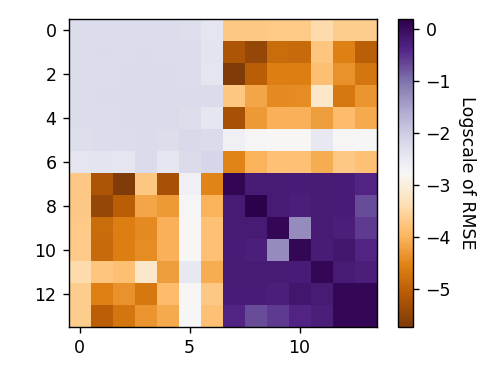

In [68]:
fig, ax = plt.subplots(figsize=(4, 3))
img = ax.imshow(np.log(rmse_2D), cmap="PuOr")
cbar = ax.figure.colorbar(img, ax=ax)
cbar.ax.set_ylabel("Logscale of RMSE", rotation=-90, va="bottom")
fig.tight_layout()

从上图中，我们可以看出，大多数情况下，当一个描述子处在 $\boldsymbol{S}_1$ 空间，另一个描述子处在 $\boldsymbol{S}_2$ 时 (即上述矩阵的非对角块，棕黄色部分)，拟合的结果通常会比较好。这与描述子的筛选过程有着直接的关系。尽管绝大多数情况下，描述子要处于不同的空间中才能得到好的结果；但还可能有极少量例外。

经过简单的查找后，应当能知道当选取 $\boldsymbol{S}_1$ 的第 2 个描述子，$\boldsymbol{S}_2$ 的第 0 个描述子时，给出的线性拟合结果是最佳的。其残差 `Delta_2D` $\boldsymbol{\Delta}_\mathrm{2D}$ 写为

In [69]:
reg = LinearRegression()
reg.fit(np.array([d_1D[2], d_2D[0]]).T, P)
Delta_2D = P - reg.predict(np.array([d_1D[2], d_2D[0]]).T)
Delta_2D

array([ 0.00406, -0.00466, -0.00297,  0.00161,  0.00196])

这与文件 [residual/res_002d_p001.dat](residual/res_002d_p001.dat) 的结果一致：

In [70]:
! cat residual/res_002d_p001.dat

    0.4058658000E-02
   -0.4655793000E-02
   -0.2972292700E-02
    0.1614245300E-02
    0.1955182100E-02


残差 `Delta_2D` $\boldsymbol{\Delta}_\mathrm{2D}$ 就将会作为第三轮描述子筛选过程的指标了。

同时，上述拟合过程给出的 RMSE 值也与 [models/top0091_002d](models/top0091_002d) 文件一致。其中，SISSO 输出的 `Feature_ID` 一栏给出的是 1-index 的 $\boldsymbol{S}_1 \cup \boldsymbol{S}_2$ 的序号。

In [71]:
! cat models/top0091_002d | head -n 5

        Rank        RMSE       MaxAE  Feature_ID
           1    0.003268    0.004656  (       3       8)
           2    0.004235    0.005166  (       2       9)
           3    0.005273    0.006898  (       5       8)
           4    0.005682    0.008797  (       2       8)


事实上，第三轮描述子筛选的过程与第二轮过程是非常类似的。我们之后就不再对第三轮进行说明。

## 最终模型与备选模型

作为用户，尽管中间过程与中间输出非常重要，也确实地能加深对 SISSO 算法的了解；但我们所最关心的是最终的结果。我们前面已经提及了从输出文件 [SISSO.out](SISSO.out) 查看最佳模型；但 SISSO 的输出中，还包含众多拟合效果也尚可的各种备选模型。

由于我们在设置中选择了 `desc_dim` 为 3，即最终描述子数量为 3；因此在查看模型时，我们也要找到 `model` 文件夹下末尾为 `003d` 为名的文件。我们打出前 6 行：

In [72]:
! cat models/top0100_003d | head -n 6

        Rank        RMSE       MaxAE  Feature_ID
           1    0.000083    0.000137  (       5      12      16)
           2    0.000097    0.000147  (       4       5      11)
           3    0.000100    0.000165  (       5      12      20)
           4    0.000107    0.000178  (       6      12      17)
           5    0.000109    0.000182  (       6      12      18)


上述的排名是通过 RMSE 为量标给出的。我们会发现，排名第一的模型就是 [SISSO.out](SISSO.out) 所给出的模型 (回见 [上文](#SISSO-运行与结果))。线性拟合的参数在下述文件：

In [73]:
! cat models/top0100_003d_coeff | head -n 6

Model_ID, [(c_i,i=0,n)_j,j=1,ntask]
           1    0.6547943803E+00   -0.2813852886E+01    0.2638598223E-01    0.4721473413E-02
           2    0.6781322860E+00    0.1483762489E+01   -0.1156767698E+01    0.3405072802E-02
           3    0.6563705862E+00   -0.2822110944E+01    0.2627937583E-01    0.3542080508E-02
           4    0.6562623115E+00    0.8694024465E+01    0.2629715431E-01    0.2124739537E-01
           5    0.6560493168E+00    0.8311600413E+01    0.2628677203E-01    0.9378780197E+01


描述子的编号 (`Feature_ID`) 储存在下述文件中。但需要注意，该文件中的 `corr=` 以后所表现的相关性并不是统一的，因此不具有意义；有意义的部分只有描述子表达式。

In [74]:
! cat -n feature_space/Uspace.name

     1	((F1*F2)/log(F3))  corr=      0.9953
     2	cos((F1*F2))  corr=      0.9949
     3	((F1*F2))^2  corr=      0.9949
     4	((F1*F2)*(F1+F2))  corr=      0.9948
     5	((F2)^6/log(F1))  corr=      0.9947
     6	((F1)^2*(F2)^3)  corr=      0.9946
     7	((F1*F2)*sqrt(F1))  corr=      0.9938
     8	(abs(F1-F2))^-1  corr=      0.9693
     9	(sqrt(F3)/abs(F1-F2))  corr=      0.9612
    10	(sin(F3)/abs(F1-F2))  corr=      0.9540
    11	(exp(F3)/abs(F1-F2))  corr=      0.9534
    12	(exp(-F3)/abs(F1-F2))  corr=      0.9486
    13	(F3/abs(F1-F2))  corr=      0.9474
    14	(cos(F2)/abs(F1-F2))  corr=      0.9468
    15	((F1)^6/(F1-F2))  corr=      0.8401
    16	((F1)^3/(F1-F2))  corr=      0.8265
    17	((F1*F2)/(F1-F2))  corr=      0.8177
    18	((F2)^6*(F1-F2))  corr=      0.8177
    19	((F1)^2/(F1-F2))  corr=      0.8100
    20	((F2)^2/(F1-F2))  corr=      0.7965
    21	((F2)^3/(F1-F2))  corr=      0.7951


其中一些简单的结论会是：

- 在较少描述子下结果良好的模型，并不意味着更多描述子下也会有更好的表现。譬如，1 号描述子在单描述子下表现最好，3, 8 号描述子在双描述子下表现最好；但这些描述子都没有在最终的三描述子模型的前五名中出现。

- 一般来说，比较好的模型中，三个描述子分别会出现在三个描述子集 $\boldsymbol{S}_1, \boldsymbol{S}_2, \boldsymbol{S}_3$ 中。但排名第 2 的模型是例外：两个描述子出现在 $\boldsymbol{S}_1$，而一个描述子出现在 $\boldsymbol{S}_2$ 中。

- 最好的若干个模型的线性拟合 RMSE 误差并不能说相差很大。

- 抛开偏置项 (Bias，即文件 [models/top0100_003d_coeff](models/top0100_003d_coeff) 的首列) 看，越靠前的描述子对预测值的贡献越大；但三个描述子分配不均的排名第 2 模型的情况会是例外，并且也存在排名第 5 的例外情况。

实际上，SISSO 给出了许多可供替代的模型。最佳和稍次的模型的表现未必相差很大；若表现稍次的模型所使用的描述子可能更符合物理直觉，那么这些描述子也不应被忽视。所以，从这个角度上讲，SISSO 不只是推荐一个具体的模型，而可以是推荐一系列表现相近的模型与描述子。譬如就上面的例子而言，用户一定会发现到描述子子结构 $f_1 f_2, \mathrm{abs} (f_1 - f_2)^{-1}, (f_1 - f_2)^{-1}$ 的重要性。因此，SISSO 可以启发用户使用这些描述子描述物理或材料问题的目的，或者从这些描述子出发进行下一步的机器学习过程。

## 参考文献